In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as mcolors

# Set style for better visualizations
plt.style.use('ggplot')
sns.set_palette("colorblind")

# Load the datasets
ipl_2022 = pd.read_csv("IPL_YEAR_23_25/ipl_2022_deliveries.csv")
ipl_2023 = pd.read_csv("IPL_YEAR_23_25/ipl_2023_deliveries.csv")
ipl_2024 = pd.read_csv("IPL_YEAR_23_25/ipl_2024_deliveries.csv")
ipl_2025 = pd.read_csv("IPL_YEAR_23_25/ipl_2025_deliveries.csv")

# Combine datasets
ipl_2022['season'] = 2022
ipl_2023['season'] = 2023
ipl_2024['season'] = 2024
ipl_2025['season'] = 2025

# Concatenate all dataframes
all_ipl = pd.concat([ipl_2022, ipl_2023, ipl_2024, ipl_2025], ignore_index=True)

# Check data
print(f"Total deliveries: {len(all_ipl)}")
print(f"Seasons: {all_ipl['season'].unique()}")
print(f"Teams: {sorted(pd.unique(all_ipl[['batting_team', 'bowling_team']].values.ravel('K')))}")

Total deliveries: 64105
Seasons: [2022 2023 2024 2025]
Teams: ['CSK', 'DC', 'GT', 'KKR', 'LSG', 'MI', 'PBKS', 'RCB', 'RR', 'SRH']


In [2]:
def preprocess_data(df):
    """Process the data for analysis"""
    # Calculate total runs (runs from bat + extras)
    df['total_runs'] = df['runs_of_bat'] + df['extras']
    
    # Create binary columns for boundaries
    df['is_four'] = df['runs_of_bat'] == 4
    df['is_six'] = df['runs_of_bat'] == 6
    
    # Create binary column for wickets
    df['is_wicket'] = ~df['wicket_type'].isna()
    
    # Extract over number as integer
    df['over_num'] = df['over'].astype(str).str.split('.').str[0].astype(int)
    
    # Mark powerplay, middle overs and death overs
    df['phase'] = 'middle'
    df.loc[df['over_num'] < 6, 'phase'] = 'powerplay'
    df.loc[df['over_num'] > 15, 'phase'] = 'death'
    
    return df

# Apply preprocessing
all_ipl = preprocess_data(all_ipl)

C:\Users\DELL-7373\AppData\Local\Temp\ipykernel_3940\3340165905.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='season', y='avg_runs_per_match', data=runs_per_match, palette='viridis')


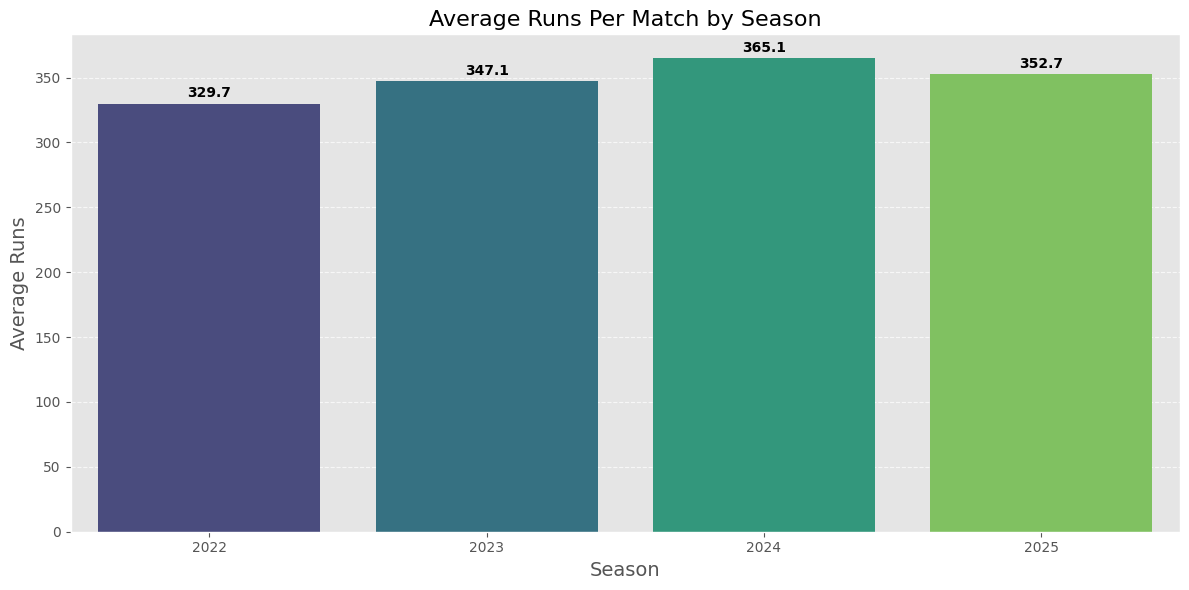

In [3]:
# Calculate average runs per match by season
runs_by_season = all_ipl.groupby('season')['total_runs'].sum().reset_index()
matches_by_season = all_ipl.groupby('season')['match_id'].nunique().reset_index()
matches_by_season.columns = ['season', 'num_matches']
runs_per_match = pd.merge(runs_by_season, matches_by_season, on='season')
runs_per_match['avg_runs_per_match'] = runs_per_match['total_runs'] / runs_per_match['num_matches']

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='season', y='avg_runs_per_match', data=runs_per_match, palette='viridis')

# Add text labels on top of bars
for i, v in enumerate(runs_per_match['avg_runs_per_match']):
    ax.text(i, v + 5, f"{v:.1f}", ha='center', fontweight='bold')

plt.title('Average Runs Per Match by Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Average Runs', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

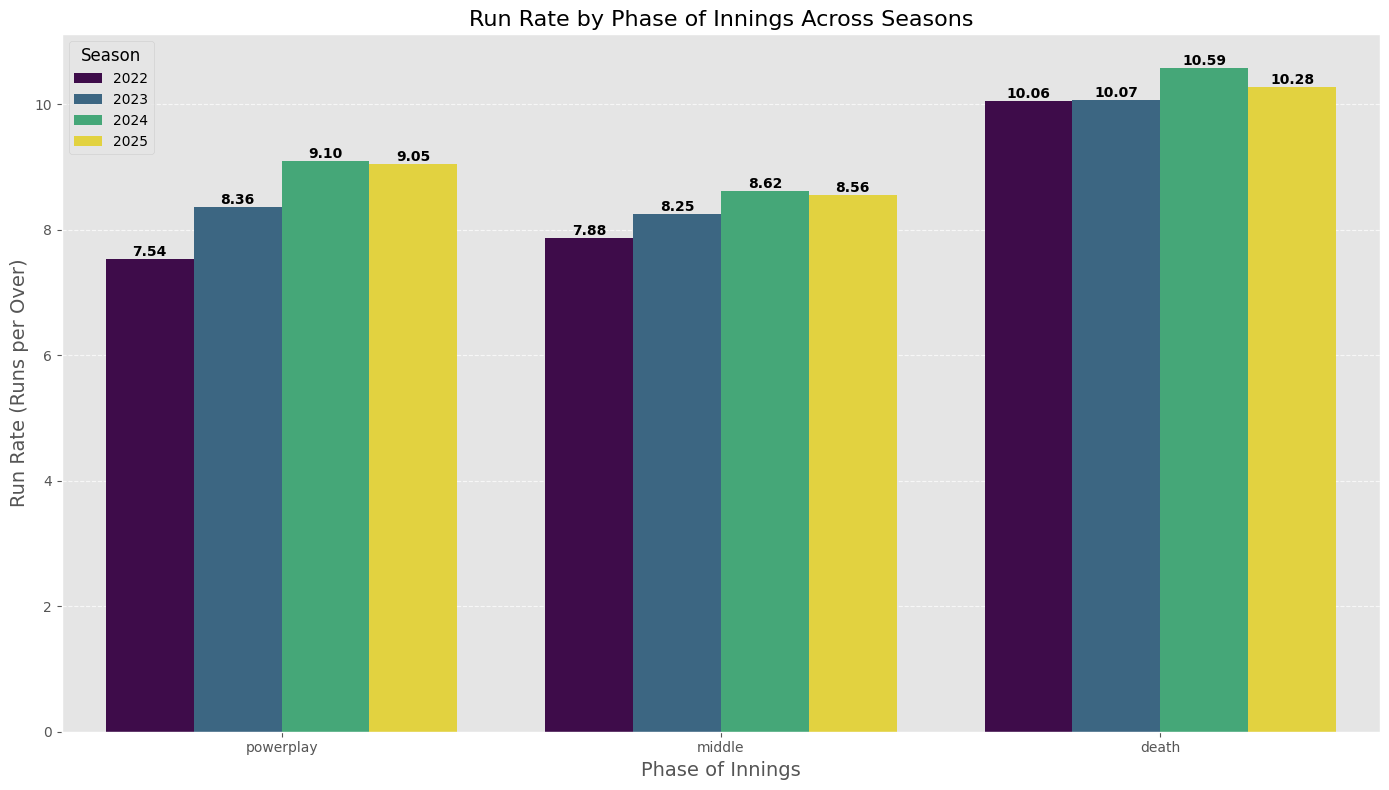

In [4]:
# Calculate run rate by phase of innings for each season
phase_runs = all_ipl.groupby(['season', 'phase'])['total_runs'].sum().reset_index()
phase_balls = all_ipl.groupby(['season', 'phase']).size().reset_index(name='balls')
phase_analysis = pd.merge(phase_runs, phase_balls, on=['season', 'phase'])
phase_analysis['run_rate'] = phase_analysis['total_runs'] * 6 / phase_analysis['balls']

# Define custom order for phases
phase_order = ['powerplay', 'middle', 'death']
phase_analysis['phase'] = pd.Categorical(phase_analysis['phase'], categories=phase_order, ordered=True)
phase_analysis = phase_analysis.sort_values(['season', 'phase'])

# Plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='phase', y='run_rate', hue='season', data=phase_analysis, palette='viridis')

# Add run rate values on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontweight='bold')

plt.title('Run Rate by Phase of Innings Across Seasons', fontsize=16)
plt.xlabel('Phase of Innings', fontsize=14)
plt.ylabel('Run Rate (Runs per Over)', fontsize=14)
plt.legend(title='Season', title_fontsize=12, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

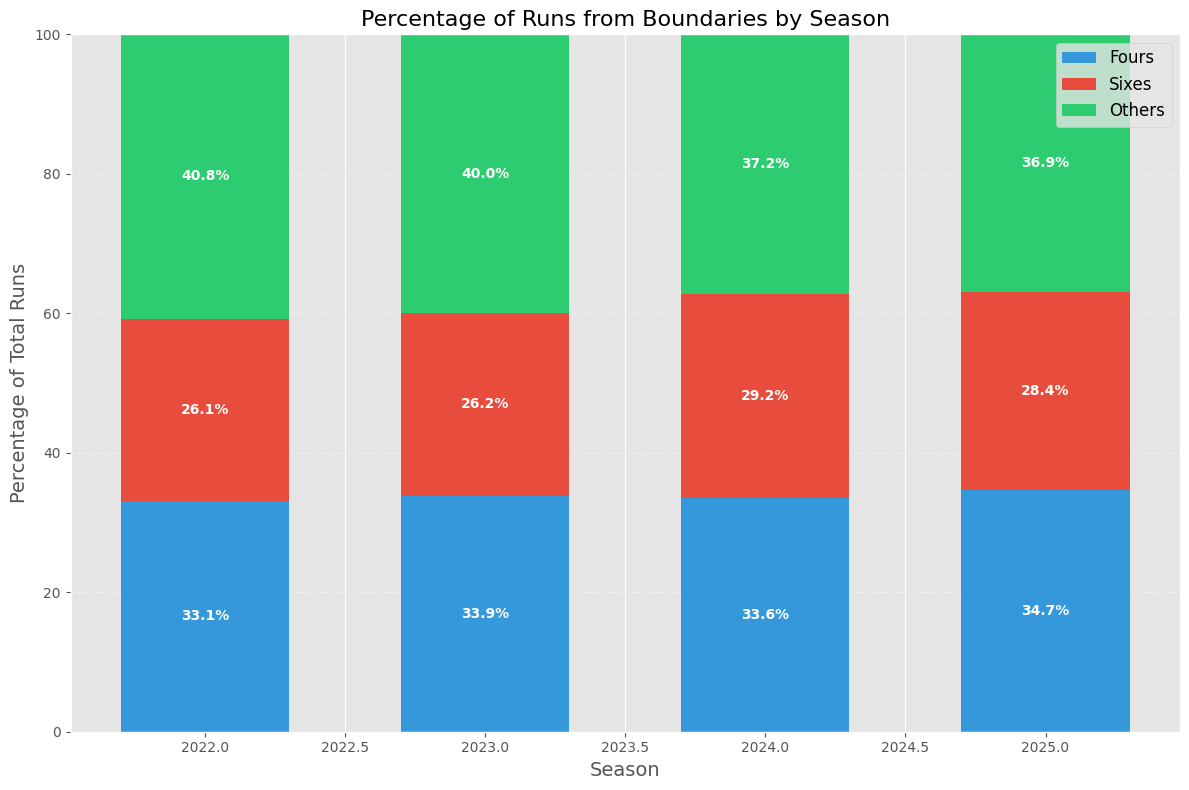

In [5]:
# Calculate boundary percentage by season
boundary_stats = all_ipl.groupby('season').agg(
    total_runs=('total_runs', 'sum'),
    total_fours=('is_four', 'sum'),
    total_sixes=('is_six', 'sum')
).reset_index()

boundary_stats['runs_from_fours'] = boundary_stats['total_fours'] * 4
boundary_stats['runs_from_sixes'] = boundary_stats['total_sixes'] * 6
boundary_stats['runs_from_others'] = boundary_stats['total_runs'] - boundary_stats['runs_from_fours'] - boundary_stats['runs_from_sixes']

# Calculate percentages
for col in ['runs_from_fours', 'runs_from_sixes', 'runs_from_others']:
    boundary_stats[f'{col}_percent'] = boundary_stats[col] * 100 / boundary_stats['total_runs']

# Prepare data for stacked bar chart
seasons = boundary_stats['season'].tolist()
fours_percent = boundary_stats['runs_from_fours_percent'].tolist()
sixes_percent = boundary_stats['runs_from_sixes_percent'].tolist()
others_percent = boundary_stats['runs_from_others_percent'].tolist()

# Plot
plt.figure(figsize=(12, 8))
bar_width = 0.6

# Create stacked bars
p1 = plt.bar(seasons, fours_percent, bar_width, color='#3498db', label='Fours')
p2 = plt.bar(seasons, sixes_percent, bar_width, bottom=fours_percent, color='#e74c3c', label='Sixes')
p3 = plt.bar(seasons, others_percent, bar_width, bottom=[fours_percent[i] + sixes_percent[i] for i in range(len(seasons))], color='#2ecc71', label='Others')

# Add percentage labels
for i, season in enumerate(seasons):
    # Label for fours
    plt.text(season, fours_percent[i]/2, f"{fours_percent[i]:.1f}%", ha='center', va='center', fontweight='bold', color='white')
    
    # Label for sixes
    plt.text(season, fours_percent[i] + sixes_percent[i]/2, f"{sixes_percent[i]:.1f}%", ha='center', va='center', fontweight='bold', color='white')
    
    # Label for others
    plt.text(season, fours_percent[i] + sixes_percent[i] + others_percent[i]/2, f"{others_percent[i]:.1f}%", ha='center', va='center', fontweight='bold', color='white')

plt.title('Percentage of Runs from Boundaries by Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Percentage of Total Runs', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

C:\Users\DELL-7373\AppData\Local\Temp\ipykernel_3940\4192659542.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wicket_counts_filtered['percentage'] = wicket_counts_filtered['count'] * 100 / total_wickets


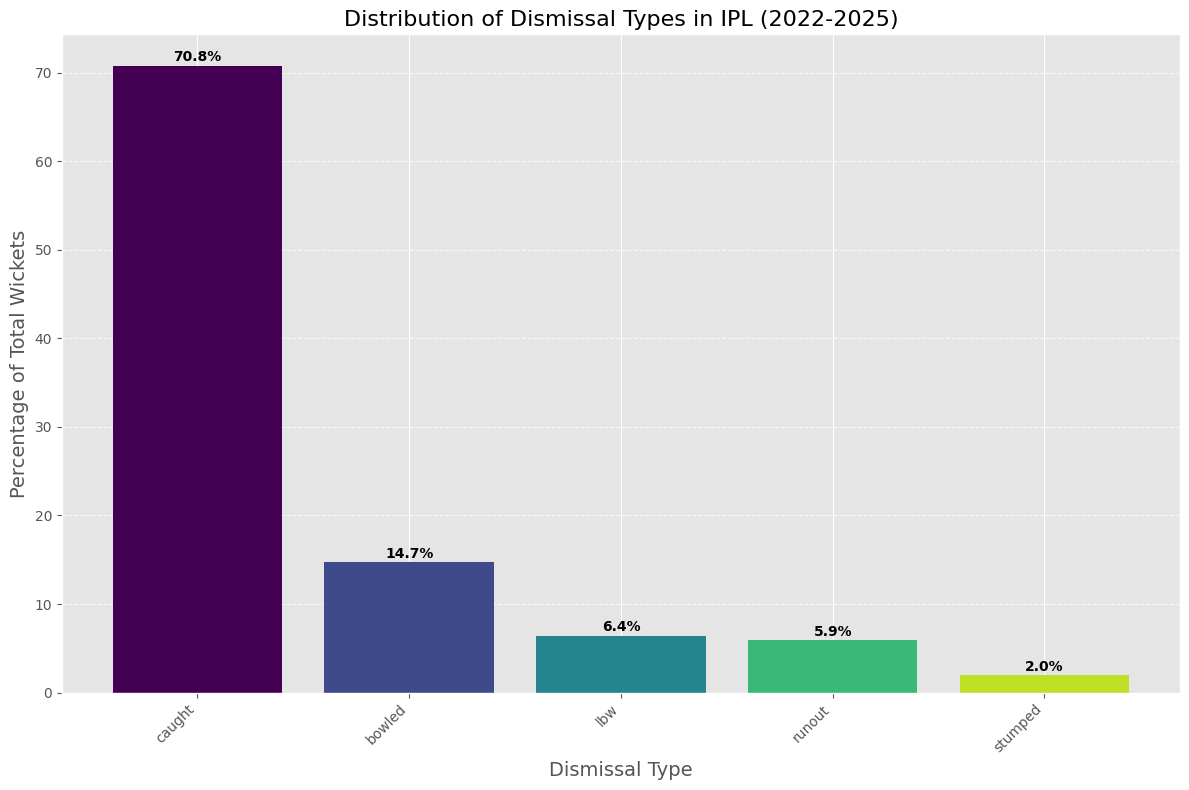

In [6]:
# Count wicket types across all seasons
wicket_counts = all_ipl[all_ipl['is_wicket']]['wicket_type'].value_counts().reset_index()
wicket_counts.columns = ['wicket_type', 'count']

# Filter out less common dismissals for clarity
min_wickets = 5
wicket_counts_filtered = wicket_counts[wicket_counts['count'] >= min_wickets]

# Calculate percentages
total_wickets = wicket_counts['count'].sum()
wicket_counts_filtered['percentage'] = wicket_counts_filtered['count'] * 100 / total_wickets

# Sort by count
wicket_counts_filtered = wicket_counts_filtered.sort_values('count', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 0.9, len(wicket_counts_filtered)))

bars = plt.bar(wicket_counts_filtered['wicket_type'], wicket_counts_filtered['percentage'], color=colors)

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', fontweight='bold')

plt.title('Distribution of Dismissal Types in IPL (2022-2025)', fontsize=16)
plt.xlabel('Dismissal Type', fontsize=14)
plt.ylabel('Percentage of Total Wickets', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

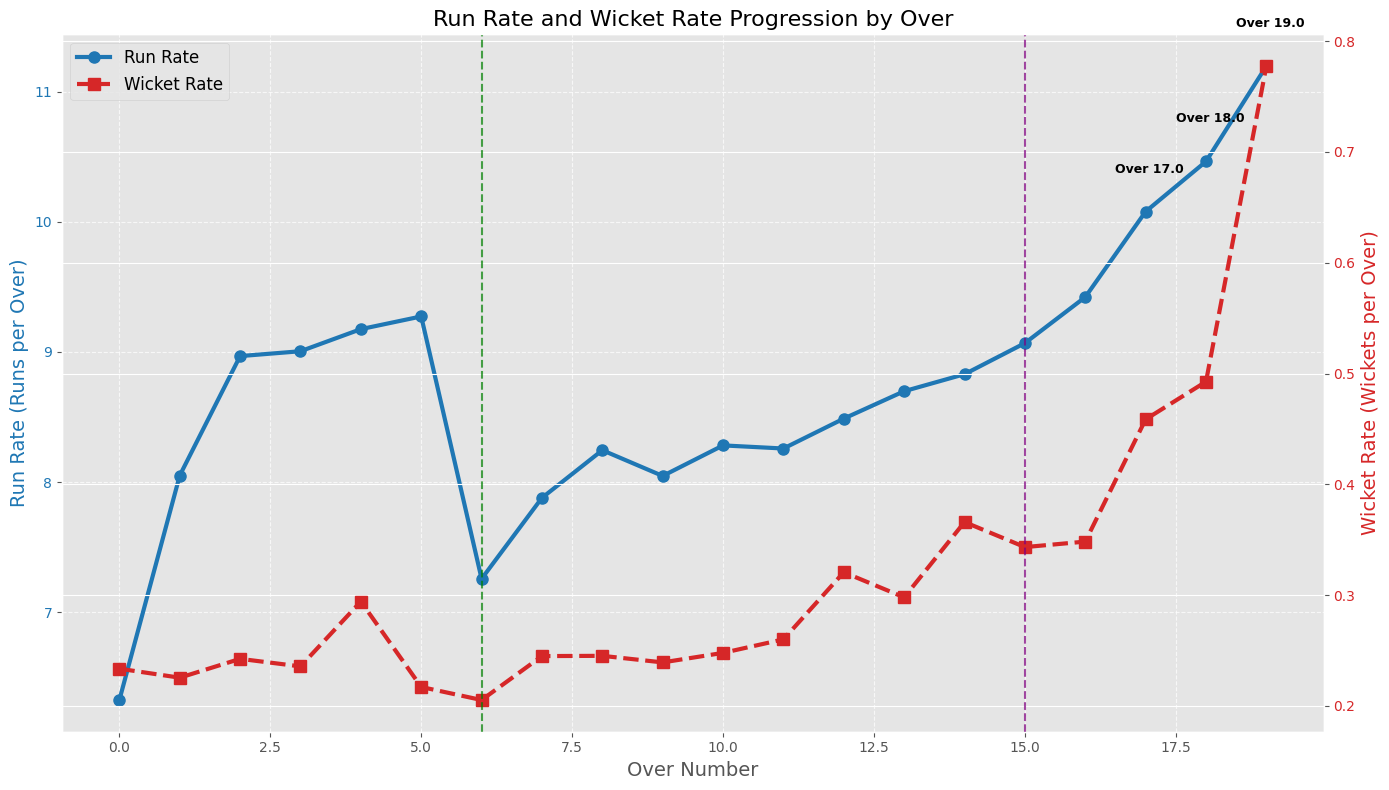

In [7]:
# Calculate over-by-over run rate
over_runs = all_ipl.groupby('over_num')['total_runs'].sum().reset_index()
over_balls = all_ipl.groupby('over_num').size().reset_index(name='balls')
over_analysis = pd.merge(over_runs, over_balls, on='over_num')
over_analysis['run_rate'] = over_analysis['total_runs'] * 6 / over_analysis['balls']
over_analysis['wickets'] = all_ipl[all_ipl['is_wicket']].groupby('over_num').size().reset_index(name='count')['count']
over_analysis['wicket_rate'] = over_analysis['wickets'] * 6 / over_analysis['balls']

# Plot run rate by over
fig, ax1 = plt.subplots(figsize=(14, 8))

# Run rate line
color = 'tab:blue'
ax1.set_xlabel('Over Number', fontsize=14)
ax1.set_ylabel('Run Rate (Runs per Over)', color=color, fontsize=14)
line1 = ax1.plot(over_analysis['over_num'], over_analysis['run_rate'], color=color, linewidth=3, marker='o', markersize=8, label='Run Rate')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.7)

# Wicket rate on secondary axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Wicket Rate (Wickets per Over)', color=color, fontsize=14)
line2 = ax2.plot(over_analysis['over_num'], over_analysis['wicket_rate'], color=color, linewidth=3, linestyle='--', marker='s', markersize=8, label='Wicket Rate')
ax2.tick_params(axis='y', labelcolor=color)

# Add vertical lines for phase boundaries
plt.axvline(x=6, color='green', linestyle='--', alpha=0.7, label='End of Powerplay')
plt.axvline(x=15, color='purple', linestyle='--', alpha=0.7, label='Start of Death Overs')

# Title and legend
plt.title('Run Rate and Wicket Rate Progression by Over', fontsize=16)
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=12)

# Annotations
for i, row in over_analysis.iterrows():
    if row['run_rate'] > 9.5 or row['wicket_rate'] > 0.4:
        ax1.annotate(f"Over {row['over_num']}",
                     xy=(row['over_num'], row['run_rate']),
                     xytext=(row['over_num']-0.5, row['run_rate']+0.3),
                     fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

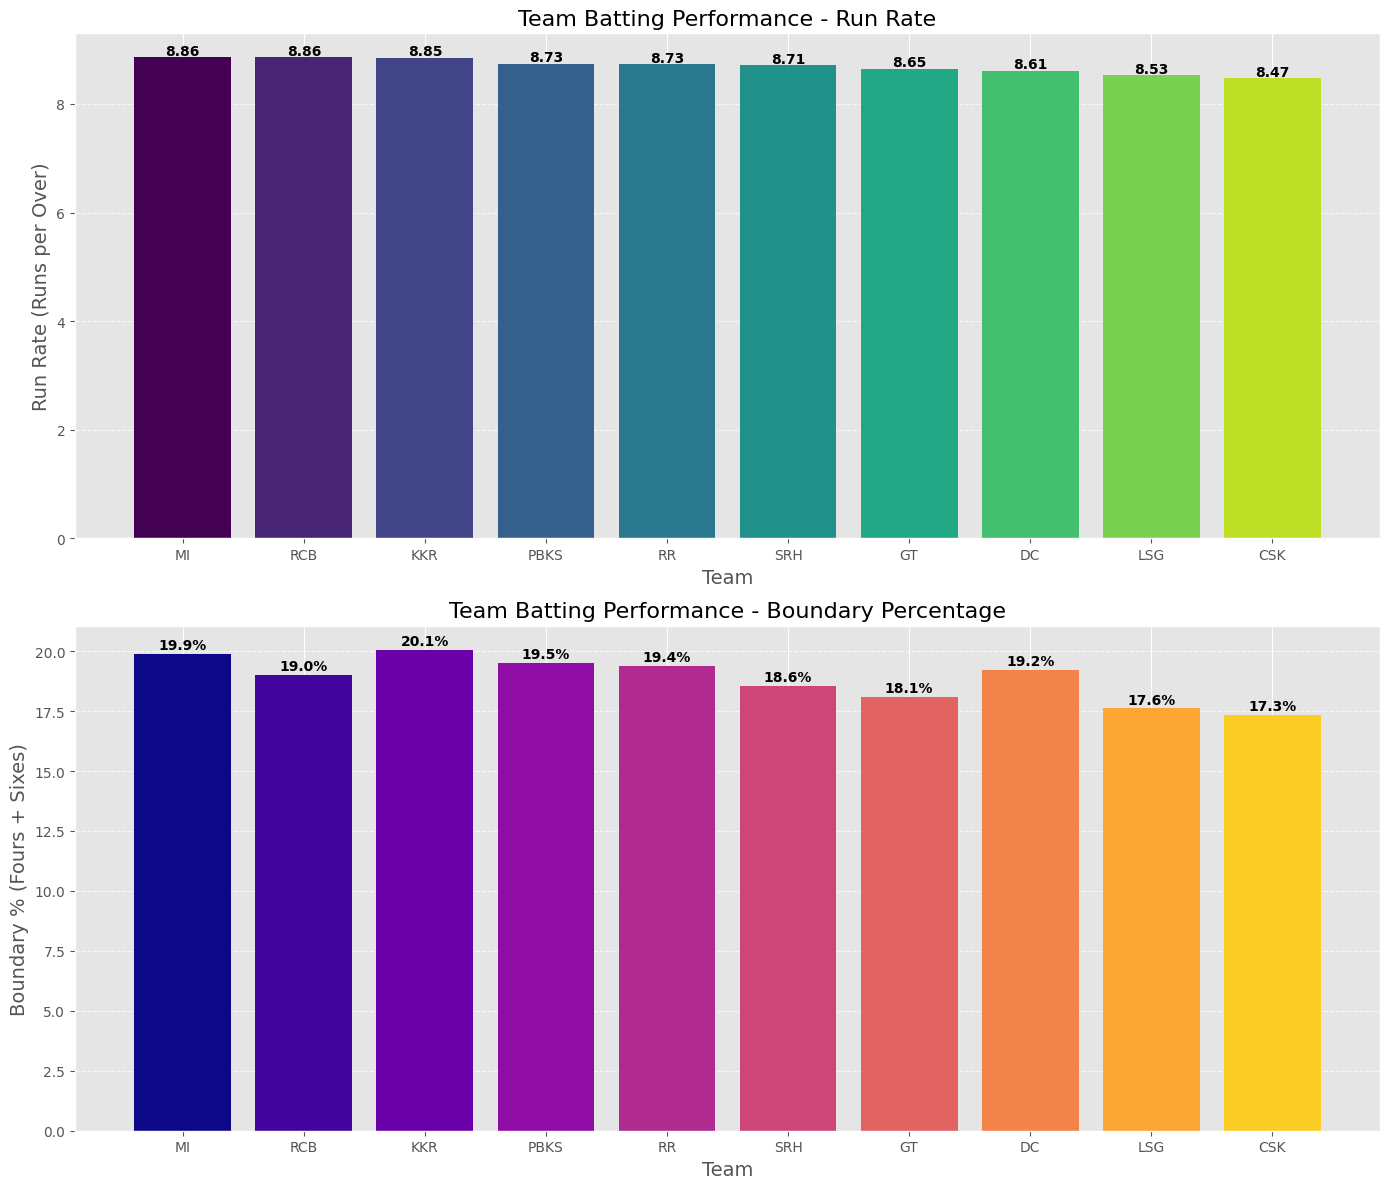

In [8]:
# Calculate team batting performance
team_batting = all_ipl.groupby('batting_team').agg(
    total_runs=('total_runs', 'sum'),
    total_balls=('total_runs', 'count'),
    total_fours=('is_four', 'sum'),
    total_sixes=('is_six', 'sum'),
    wickets_lost=('is_wicket', 'sum')
).reset_index()

team_batting['run_rate'] = team_batting['total_runs'] * 6 / team_batting['total_balls']
team_batting['boundary_percentage'] = (team_batting['total_fours'] + team_batting['total_sixes']) * 100 / team_batting['total_balls']

# Sort teams by run rate
team_batting = team_batting.sort_values('run_rate', ascending=False)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [1, 1]})

# Run rate plot
bars1 = ax1.bar(team_batting['batting_team'], team_batting['run_rate'], color=plt.cm.viridis(np.linspace(0, 0.9, len(team_batting))))
ax1.set_title('Team Batting Performance - Run Rate', fontsize=16)
ax1.set_xlabel('Team', fontsize=14)
ax1.set_ylabel('Run Rate (Runs per Over)', fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add run rate labels on top of bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{height:.2f}', ha='center', fontweight='bold')

# Boundary percentage plot
bars2 = ax2.bar(team_batting['batting_team'], team_batting['boundary_percentage'], color=plt.cm.plasma(np.linspace(0, 0.9, len(team_batting))))
ax2.set_title('Team Batting Performance - Boundary Percentage', fontsize=16)
ax2.set_xlabel('Team', fontsize=14)
ax2.set_ylabel('Boundary % (Fours + Sixes)', fontsize=14)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add boundary percentage labels on top of bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.2,
            f'{height:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

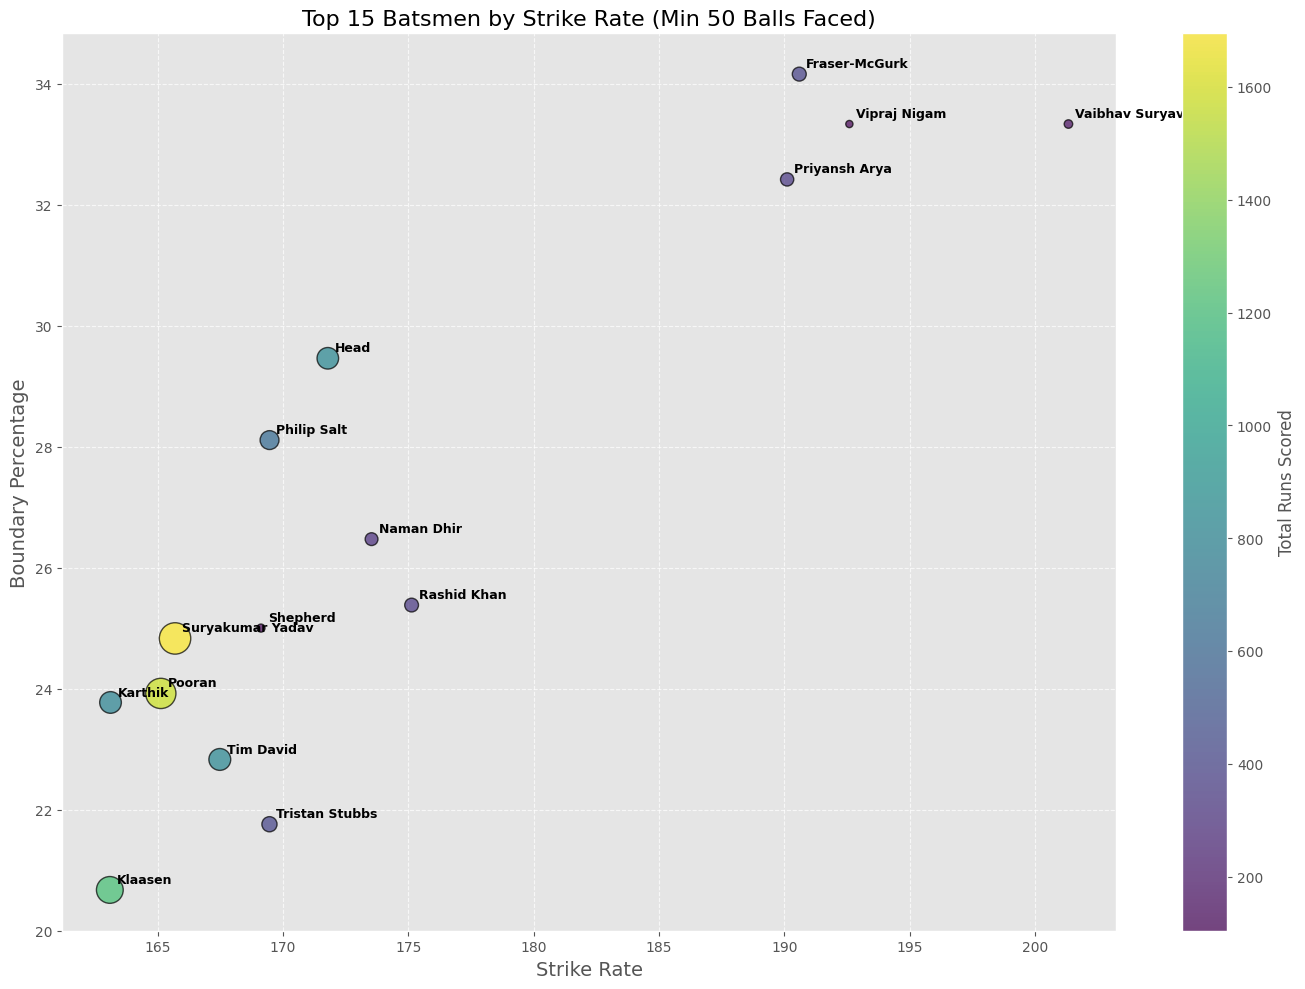

In [9]:
# Calculate batsman performance (minimum 50 balls faced)
min_balls = 50
batsman_perf = all_ipl.groupby('striker').agg(
    total_runs=('runs_of_bat', 'sum'),
    balls_faced=('runs_of_bat', 'count'),
    fours=('is_four', 'sum'),
    sixes=('is_six', 'sum')
).reset_index()

batsman_perf = batsman_perf[batsman_perf['balls_faced'] >= min_balls]
batsman_perf['strike_rate'] = batsman_perf['total_runs'] * 100 / batsman_perf['balls_faced']
batsman_perf['boundary_percentage'] = (batsman_perf['fours'] + batsman_perf['sixes']) * 100 / batsman_perf['balls_faced']

# Sort batsmen by strike rate and get top 15
top_batsmen = batsman_perf.sort_values('strike_rate', ascending=False).head(15)

# Plot
plt.figure(figsize=(14, 10))

# Create scatter plot
scatter = plt.scatter(top_batsmen['strike_rate'], top_batsmen['boundary_percentage'], 
                     s=top_batsmen['balls_faced']/2, # Size based on balls faced
                     c=top_batsmen['total_runs'], # Color based on total runs
                     alpha=0.7, cmap='viridis', 
                     edgecolors='black', linewidths=1)

# Add player names as annotations
for i, batsman in enumerate(top_batsmen['striker']):
    plt.annotate(batsman, 
                 (top_batsmen.iloc[i]['strike_rate'], top_batsmen.iloc[i]['boundary_percentage']),
                 xytext=(5, 5), textcoords='offset points', 
                 fontsize=9, fontweight='bold')

plt.colorbar(scatter, label='Total Runs Scored')
plt.title('Top 15 Batsmen by Strike Rate (Min 50 Balls Faced)', fontsize=16)
plt.xlabel('Strike Rate', fontsize=14)
plt.ylabel('Boundary Percentage', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

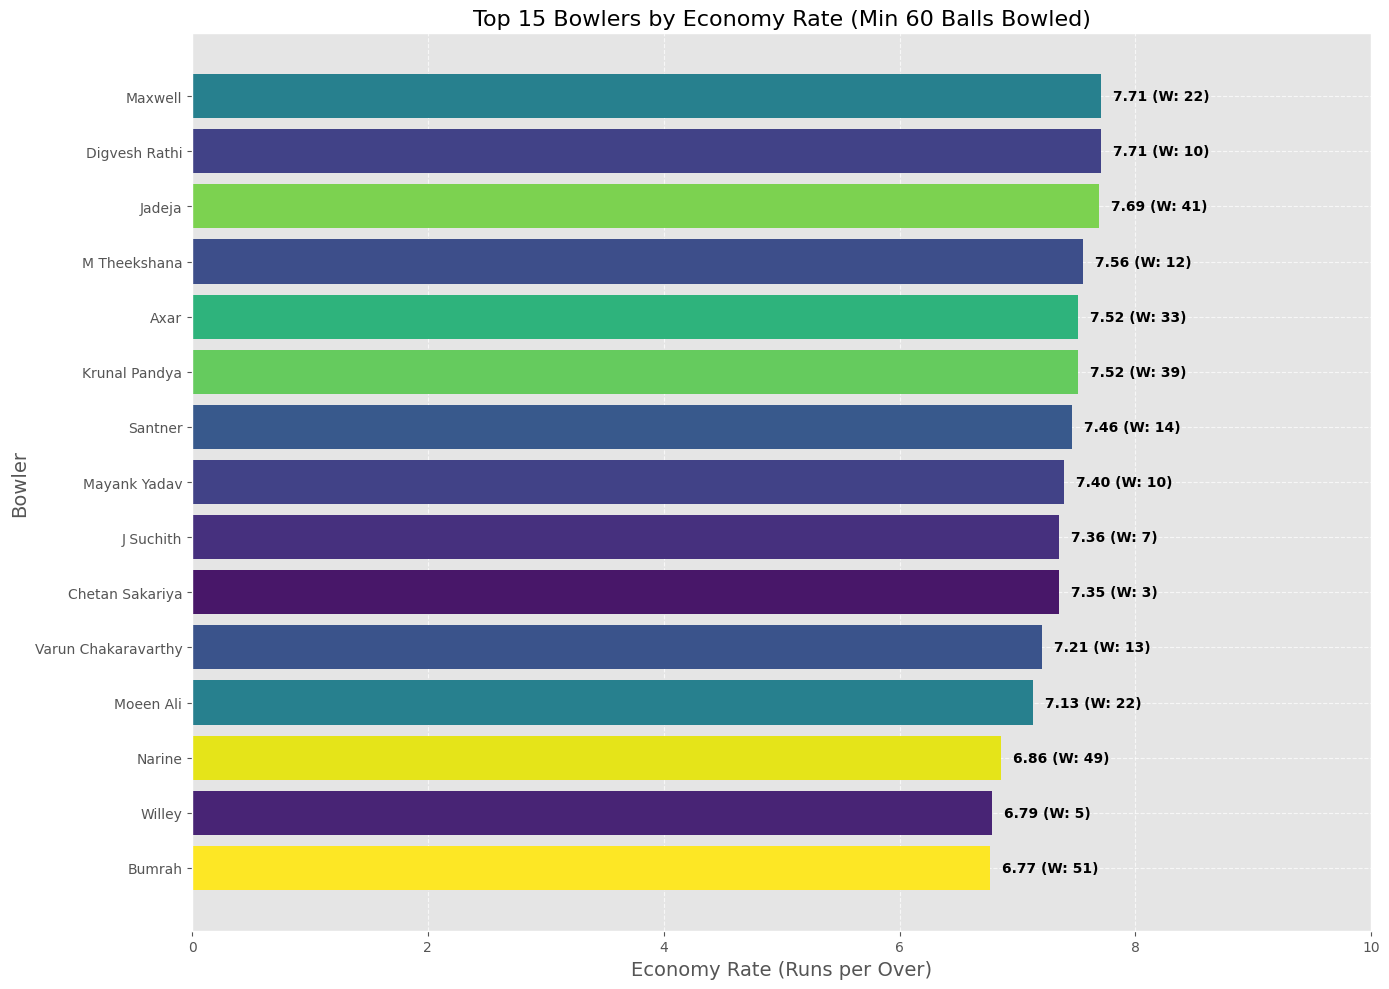

In [10]:
# Calculate bowler performance (minimum 60 balls bowled)
min_balls_bowled = 60
bowler_perf = all_ipl.groupby('bowler').agg(
    runs_conceded=('total_runs', 'sum'),
    balls_bowled=('total_runs', 'count'),
    wickets=('is_wicket', 'sum')
).reset_index()

bowler_perf = bowler_perf[bowler_perf['balls_bowled'] >= min_balls_bowled]
bowler_perf['economy'] = bowler_perf['runs_conceded'] * 6 / bowler_perf['balls_bowled']
bowler_perf['strike_rate'] = bowler_perf['balls_bowled'] / bowler_perf['wickets']
bowler_perf['strike_rate'] = bowler_perf['strike_rate'].replace(float('inf'), 0)  # Handle div by zero

# Sort by economy rate
best_economy = bowler_perf.sort_values('economy').head(15)

# Plot horizontal bar chart for economy rate
plt.figure(figsize=(14, 10))

# Create horizontal bars colored by wickets taken
bars = plt.barh(best_economy['bowler'], best_economy['economy'], 
               color=plt.cm.viridis(best_economy['wickets']/best_economy['wickets'].max()))

# Add economy rate labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    wickets = best_economy.iloc[i]['wickets']
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
             f"{width:.2f} (W: {int(wickets)})", 
             va='center', fontweight='bold')

plt.title('Top 15 Bowlers by Economy Rate (Min 60 Balls Bowled)', fontsize=16)
plt.xlabel('Economy Rate (Runs per Over)', fontsize=14)
plt.ylabel('Bowler', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 10)
plt.tight_layout()
plt.show()

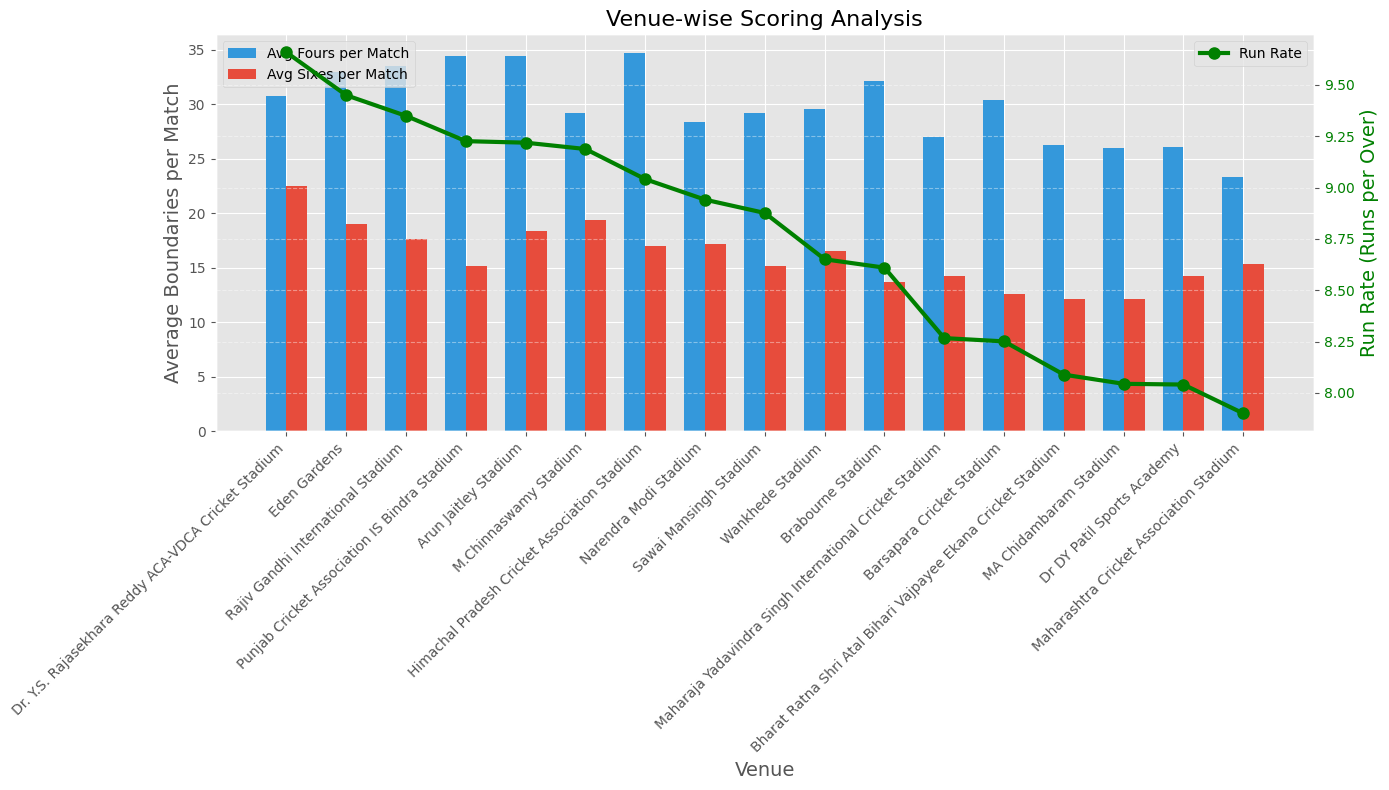

In [11]:
# Calculate venue-wise scoring patterns
venue_runs = all_ipl.groupby('venue').agg(
    total_runs=('total_runs', 'sum'),
    total_balls=('total_runs', 'count'),
    fours=('is_four', 'sum'),
    sixes=('is_six', 'sum'),
    matches=('match_id', 'nunique')
).reset_index()

venue_runs['run_rate'] = venue_runs['total_runs'] * 6 / venue_runs['total_balls']
venue_runs['avg_fours_per_match'] = venue_runs['fours'] / venue_runs['matches']
venue_runs['avg_sixes_per_match'] = venue_runs['sixes'] / venue_runs['matches']

# Include only venues with at least 2 matches
venue_runs = venue_runs[venue_runs['matches'] >= 2]

# Sort by run rate
venue_runs = venue_runs.sort_values('run_rate', ascending=False)

# Shorten venue names for display
venue_runs['venue_short'] = venue_runs['venue'].str.split(',').str[0]

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(venue_runs))
width = 0.35

# Create grouped bar chart for boundaries
ax.bar(x - width/2, venue_runs['avg_fours_per_match'], width, label='Avg Fours per Match', color='#3498db')
ax.bar(x + width/2, venue_runs['avg_sixes_per_match'], width, label='Avg Sixes per Match', color='#e74c3c')

# Add a line for run rate on secondary axis
ax2 = ax.twinx()
ax2.plot(x, venue_runs['run_rate'], 'go-', linewidth=3, markersize=8, label='Run Rate')
ax2.set_ylabel('Run Rate (Runs per Over)', color='g', fontsize=14)
ax2.tick_params(axis='y', labelcolor='g')

# Configure primary axis
ax.set_xlabel('Venue', fontsize=14)
ax.set_ylabel('Average Boundaries per Match', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(venue_runs['venue_short'], rotation=45, ha='right')
ax.legend(loc='upper left')

# Configure secondary axis
ax2.legend(loc='upper right')

plt.title('Venue-wise Scoring Analysis', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.4, axis='y')
plt.tight_layout()
plt.show()

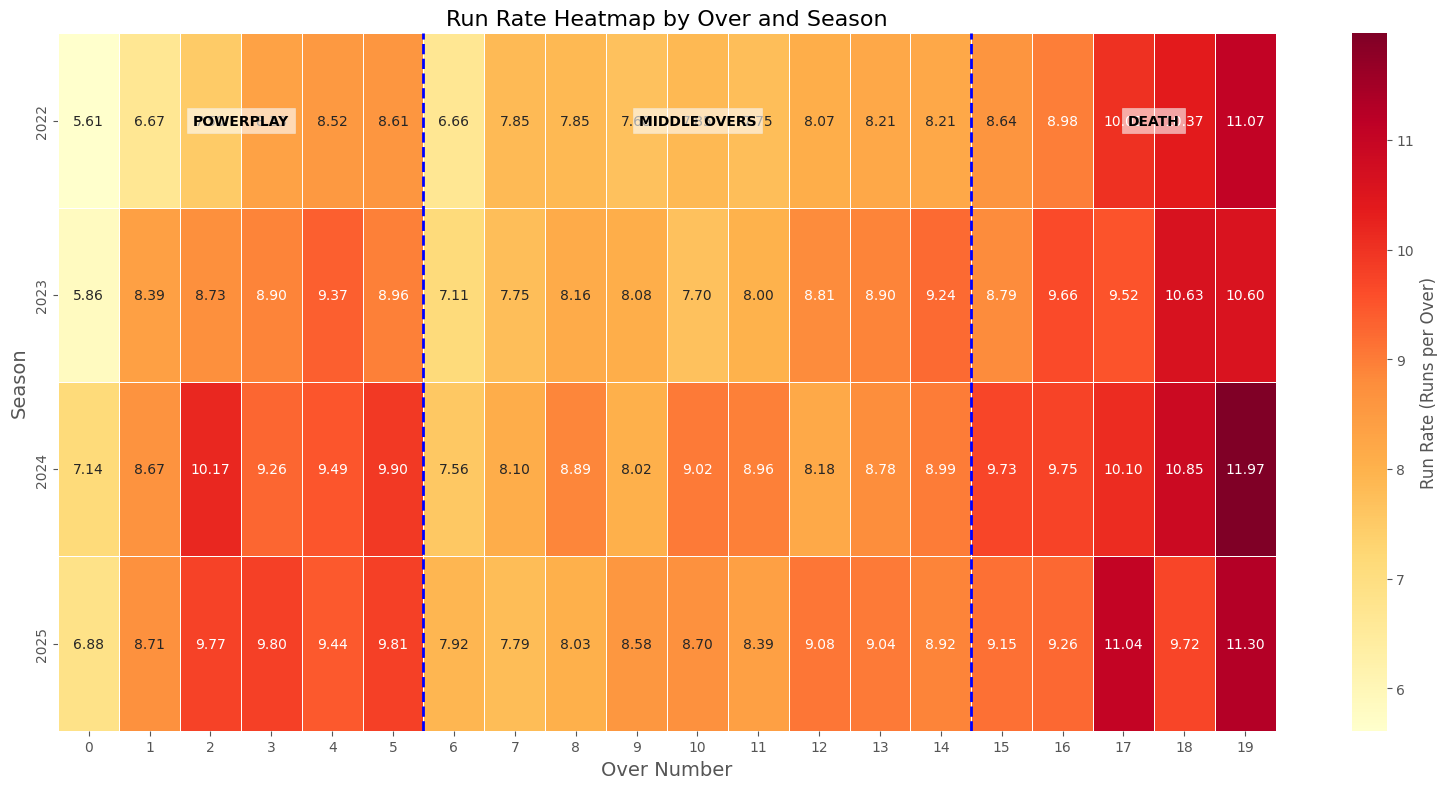

In [12]:
# Create over-by-season heatmap to show how scoring patterns evolve
over_season_runs = all_ipl.groupby(['season', 'over_num'])['total_runs'].sum().reset_index()
over_season_balls = all_ipl.groupby(['season', 'over_num']).size().reset_index(name='balls')

over_season_analysis = pd.merge(over_season_runs, over_season_balls, on=['season', 'over_num'])
over_season_analysis['run_rate'] = over_season_analysis['total_runs'] * 6 / over_season_analysis['balls']

# Create pivot table for heatmap
heatmap_data = over_season_analysis.pivot(index='season', columns='over_num', values='run_rate')

# Plot heatmap
plt.figure(figsize=(16, 8))
ax = sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt=".2f", linewidths=.5, cbar_kws={'label': 'Run Rate (Runs per Over)'})

# Add phase lines
for i in [6, 15]:  # Powerplay ends at over 6, death overs start at over 16
    plt.axvline(x=i, color='blue', linestyle='--', linewidth=2)

# Add annotations for phases
plt.text(3, 0.5, 'POWERPLAY', color='black', weight='bold', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6))
plt.text(10.5, 0.5, 'MIDDLE OVERS', color='black', weight='bold', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6))
plt.text(18, 0.5, 'DEATH', color='black', weight='bold', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6))

plt.title('Run Rate Heatmap by Over and Season', fontsize=16)
plt.ylabel('Season', fontsize=14)
plt.xlabel('Over Number', fontsize=14)
plt.tight_layout()
plt.show()

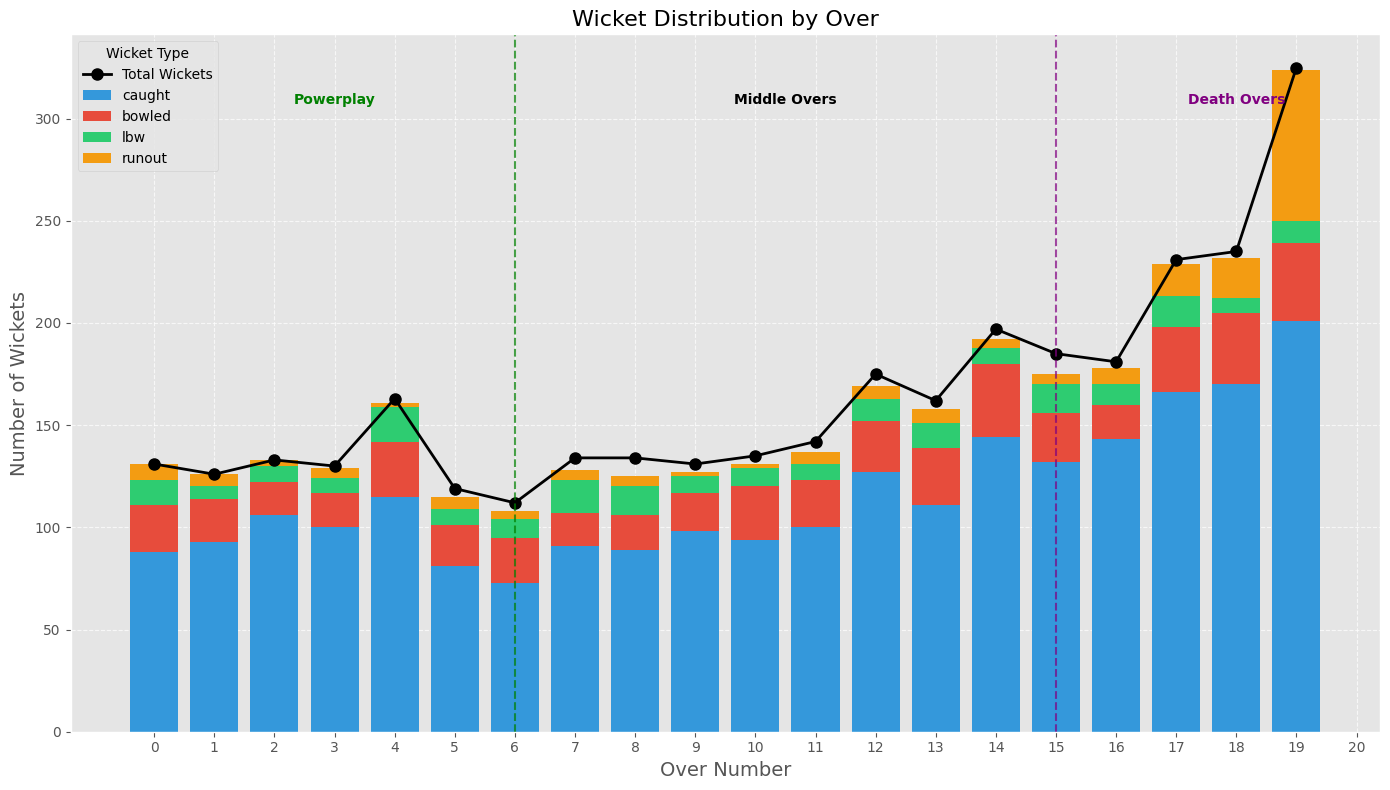

In [13]:
# Analyze wicket distribution by over
wicket_by_over = all_ipl[all_ipl['is_wicket']].groupby(['over_num', 'wicket_type']).size().unstack().fillna(0)

# Calculate total wickets per over
wicket_by_over['total'] = wicket_by_over.sum(axis=1)
wicket_by_over = wicket_by_over.sort_index()

# Get the most common wicket types
top_wicket_types = all_ipl[all_ipl['is_wicket']]['wicket_type'].value_counts().nlargest(4).index.tolist()

# Plot
plt.figure(figsize=(14, 8))

# Plot stacked bars for top wicket types
bottom = np.zeros(20)  # Assuming 20 overs
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for i, wicket_type in enumerate(top_wicket_types):
    if wicket_type in wicket_by_over.columns:
        plt.bar(wicket_by_over.index, wicket_by_over[wicket_type], bottom=bottom, label=wicket_type, color=colors[i])
        bottom += wicket_by_over[wicket_type].values

# Add line for total wickets
plt.plot(wicket_by_over.index, wicket_by_over['total'], 'ko-', linewidth=2, markersize=8, label='Total Wickets')

# Add vertical lines for phase boundaries
plt.axvline(x=6, color='green', linestyle='--', alpha=0.7)
plt.axvline(x=15, color='purple', linestyle='--', alpha=0.7)

# Add phase labels
plt.text(3, plt.ylim()[1]*0.9, 'Powerplay', color='green', weight='bold', ha='center')
plt.text(10.5, plt.ylim()[1]*0.9, 'Middle Overs', color='black', weight='bold', ha='center')
plt.text(18, plt.ylim()[1]*0.9, 'Death Overs', color='purple', weight='bold', ha='center')

plt.title('Wicket Distribution by Over', fontsize=16)
plt.xlabel('Over Number', fontsize=14)
plt.ylabel('Number of Wickets', fontsize=14)
plt.xticks(range(0, 21))
plt.legend(title='Wicket Type', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

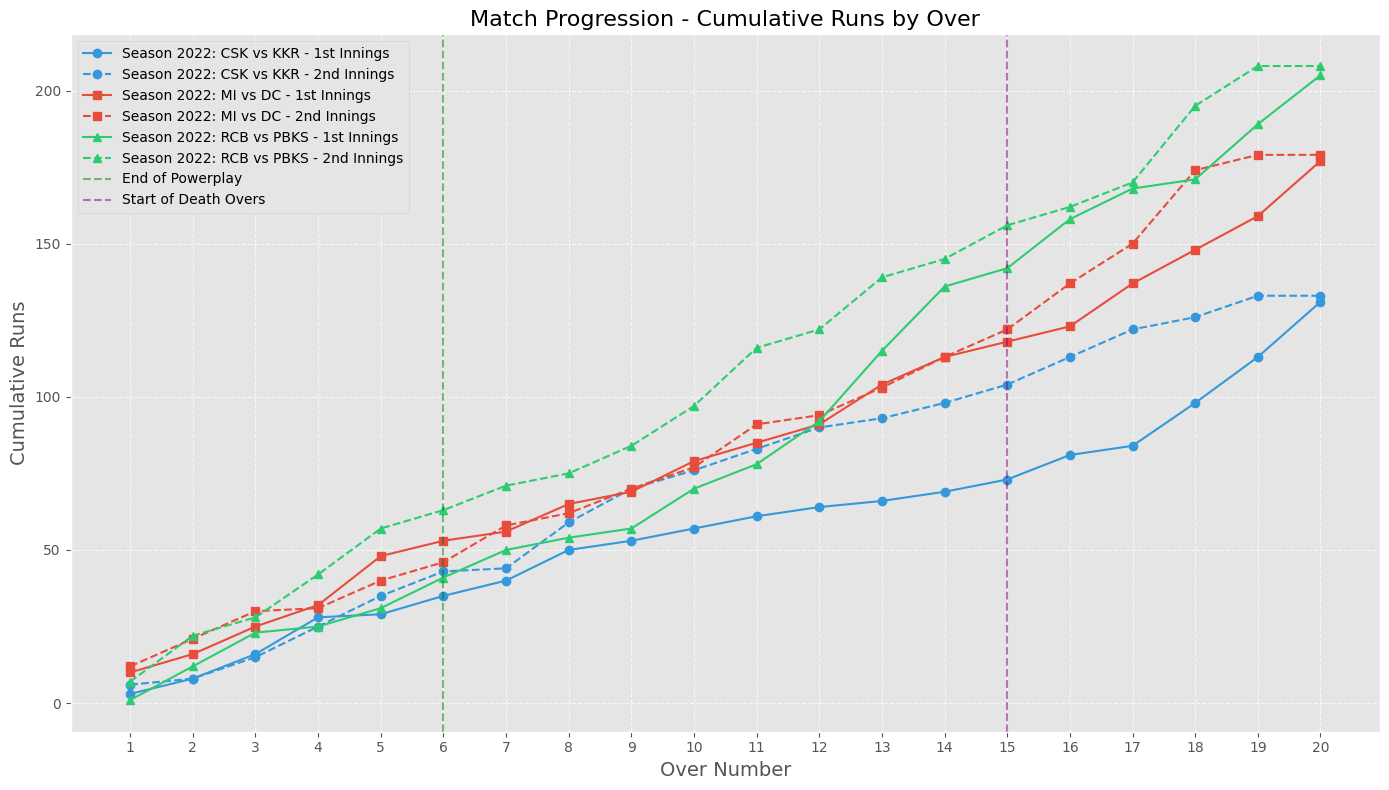

In [14]:
# Analyze match progression by calculating cumulative runs
def calculate_match_progression(match_id, df):
    """Calculate cumulative runs by over for a specific match"""
    match_data = df[df['match_id'] == match_id].sort_values(['innings', 'over'])
    
    # Initialize data structures
    overs = []
    cum_runs_innings1 = []
    cum_runs_innings2 = []
    
    # Calculate cumulative runs
    for innings in [1, 2]:
        innings_data = match_data[match_data['innings'] == innings]
        cum_runs = 0
        
        for over_num in range(20):
            over_data = innings_data[innings_data['over_num'] == over_num]
            over_runs = over_data['total_runs'].sum()
            cum_runs += over_runs
            
            if innings == 1:
                overs.append(over_num + 1)
                cum_runs_innings1.append(cum_runs)
            else:
                cum_runs_innings2.append(cum_runs)
    
    return overs, cum_runs_innings1, cum_runs_innings2

# Get unique matches
matches = all_ipl['match_id'].unique()

# Select first match from 2022, 2023, and 2024 for comparison
selected_matches = [matches[i] for i in range(min(3, len(matches)))]

# Create multiline plot
plt.figure(figsize=(14, 8))

colors = ['#3498db', '#e74c3c', '#2ecc71']
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^']

for i, match_id in enumerate(selected_matches):
    season = all_ipl[all_ipl['match_id'] == match_id]['season'].iloc[0]
    teams = all_ipl[all_ipl['match_id'] == match_id][['batting_team', 'bowling_team']].iloc[0]
    match_label = f"Season {season}: {teams['batting_team']} vs {teams['bowling_team']}"
    
    overs, cum_runs_innings1, cum_runs_innings2 = calculate_match_progression(match_id, all_ipl)
    
    if len(cum_runs_innings1) > 0:
        plt.plot(overs, cum_runs_innings1, color=colors[i], linestyle=linestyles[0], 
                 marker=markers[i], markersize=6, label=f"{match_label} - 1st Innings")
    
    if len(cum_runs_innings2) > 0:
        plt.plot(overs, cum_runs_innings2, color=colors[i], linestyle=linestyles[1], 
                 marker=markers[i], markersize=6, label=f"{match_label} - 2nd Innings")

# Add vertical lines for phase boundaries
plt.axvline(x=6, color='green', linestyle='--', alpha=0.5, label='End of Powerplay')
plt.axvline(x=15, color='purple', linestyle='--', alpha=0.5, label='Start of Death Overs')

plt.title('Match Progression - Cumulative Runs by Over', fontsize=16)
plt.xlabel('Over Number', fontsize=14)
plt.ylabel('Cumulative Runs', fontsize=14)
plt.xticks(range(1, 21))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

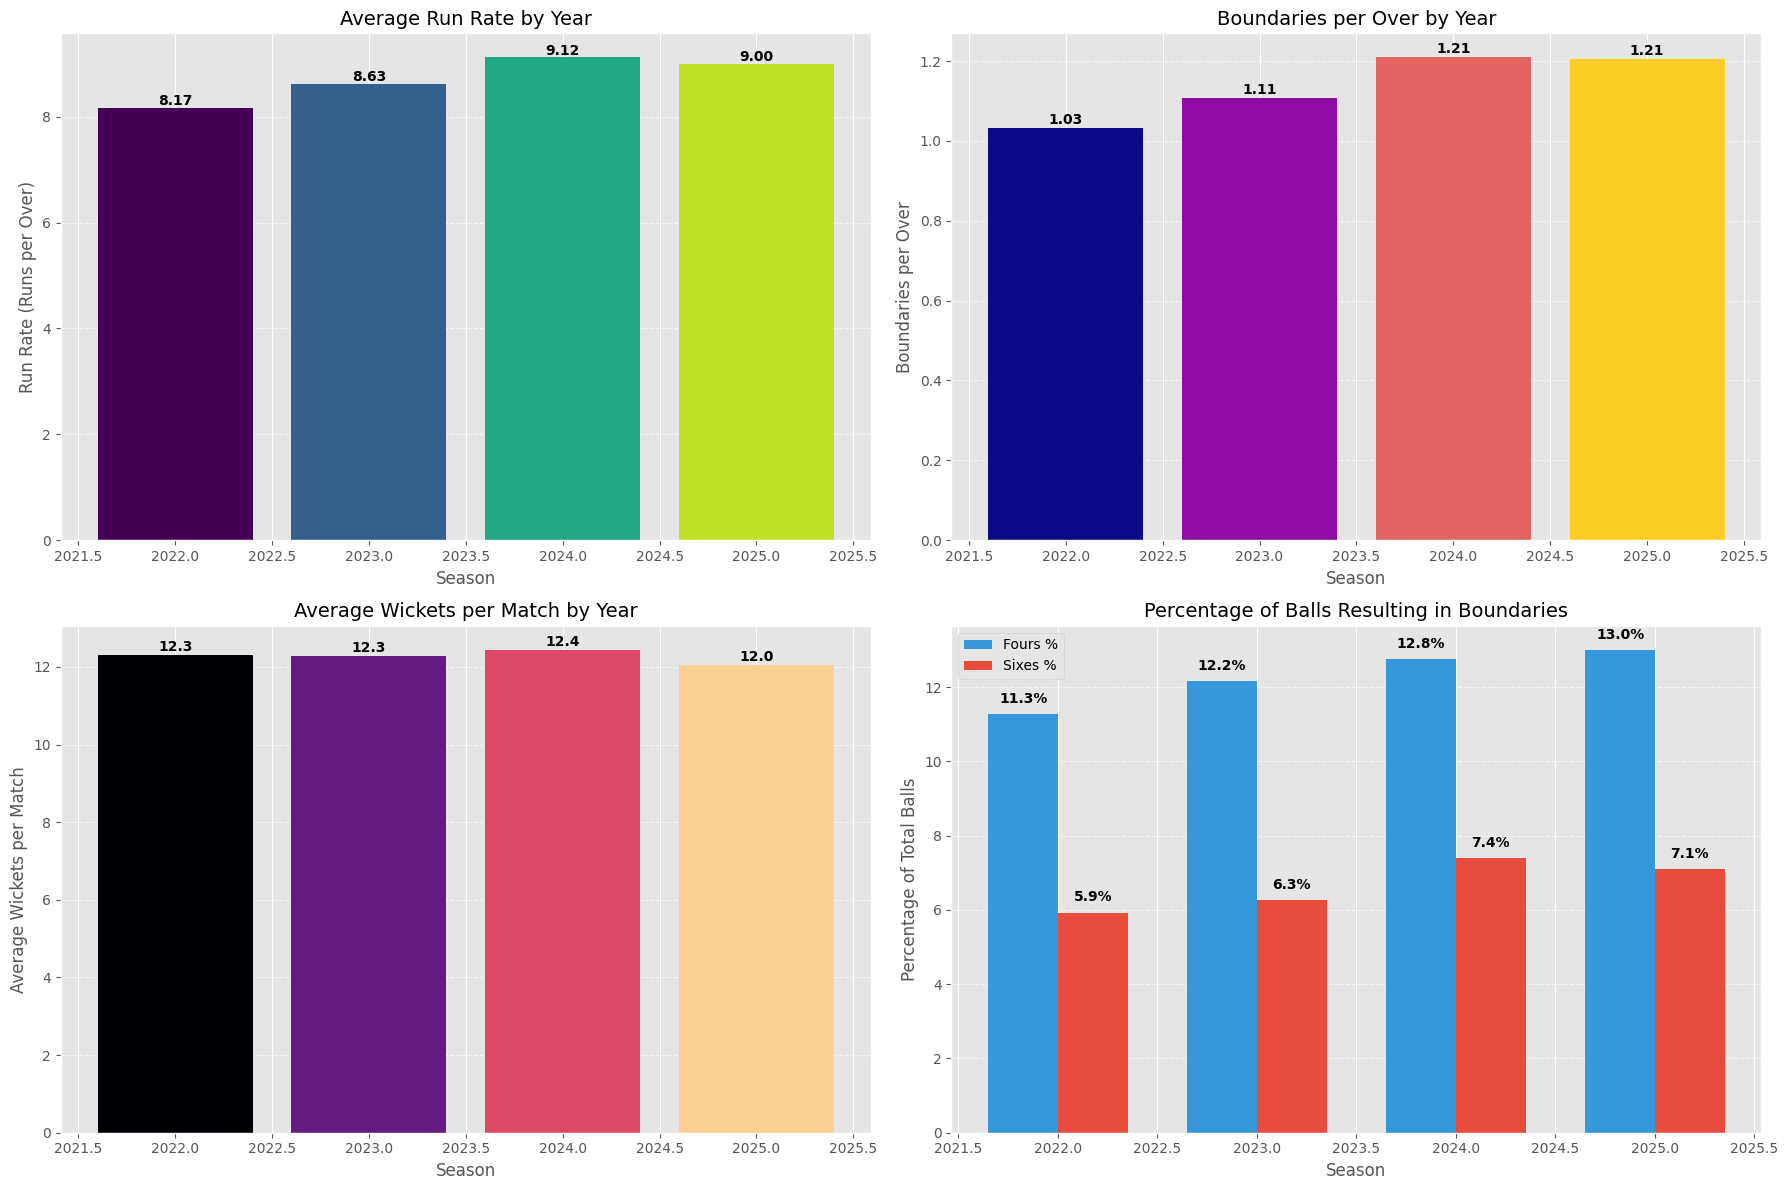

In [15]:
# Calculate year-by-year run rates
yearly_runs = all_ipl.groupby('season')['total_runs'].sum().reset_index()
yearly_balls = all_ipl.groupby('season').size().reset_index(name='balls')
yearly_analysis = pd.merge(yearly_runs, yearly_balls, on='season')
yearly_analysis['run_rate'] = yearly_analysis['total_runs'] * 6 / yearly_analysis['balls']

# Calculate other metrics by year
yearly_analysis['fours'] = all_ipl.groupby('season')['is_four'].sum().values
yearly_analysis['sixes'] = all_ipl.groupby('season')['is_six'].sum().values
yearly_analysis['wickets'] = all_ipl.groupby('season')['is_wicket'].sum().values
yearly_analysis['boundaries_per_over'] = (yearly_analysis['fours'] + yearly_analysis['sixes']) * 6 / yearly_analysis['balls']
yearly_analysis['avg_wickets_per_match'] = yearly_analysis['wickets'] / all_ipl.groupby('season')['match_id'].nunique().values

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Run Rate by Year
ax1 = axes[0, 0]
bars = ax1.bar(yearly_analysis['season'], yearly_analysis['run_rate'], color=plt.cm.viridis(np.linspace(0, 0.9, len(yearly_analysis))))
ax1.set_title('Average Run Rate by Year', fontsize=14)
ax1.set_xlabel('Season', fontsize=12)
ax1.set_ylabel('Run Rate (Runs per Over)', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{height:.2f}', ha='center', fontweight='bold')

# 2. Boundaries per Over by Year
ax2 = axes[0, 1]
bars = ax2.bar(yearly_analysis['season'], yearly_analysis['boundaries_per_over'], color=plt.cm.plasma(np.linspace(0, 0.9, len(yearly_analysis))))
ax2.set_title('Boundaries per Over by Year', fontsize=14)
ax2.set_xlabel('Season', fontsize=12)
ax2.set_ylabel('Boundaries per Over', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.2f}', ha='center', fontweight='bold')

# 3. Average Wickets per Match by Year
ax3 = axes[1, 0]
bars = ax3.bar(yearly_analysis['season'], yearly_analysis['avg_wickets_per_match'], color=plt.cm.magma(np.linspace(0, 0.9, len(yearly_analysis))))
ax3.set_title('Average Wickets per Match by Year', fontsize=14)
ax3.set_xlabel('Season', fontsize=12)
ax3.set_ylabel('Average Wickets per Match', fontsize=12)
ax3.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.1f}', ha='center', fontweight='bold')

# 4. 4s vs 6s Trend
ax4 = axes[1, 1]
x = yearly_analysis['season']
width = 0.35
ax4.bar(x - width/2, yearly_analysis['fours']/yearly_analysis['balls']*100, width, label='Fours %', color='#3498db')
ax4.bar(x + width/2, yearly_analysis['sixes']/yearly_analysis['balls']*100, width, label='Sixes %', color='#e74c3c')
ax4.set_title('Percentage of Balls Resulting in Boundaries', fontsize=14)
ax4.set_xlabel('Season', fontsize=12)
ax4.set_ylabel('Percentage of Total Balls', fontsize=12)
ax4.legend()
ax4.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels
for i in range(len(x)):
    fours_pct = yearly_analysis['fours'].iloc[i]/yearly_analysis['balls'].iloc[i]*100
    sixes_pct = yearly_analysis['sixes'].iloc[i]/yearly_analysis['balls'].iloc[i]*100
    
    ax4.text(x.iloc[i] - width/2, fours_pct + 0.3, f'{fours_pct:.1f}%', ha='center', fontweight='bold')
    ax4.text(x.iloc[i] + width/2, sixes_pct + 0.3, f'{sixes_pct:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

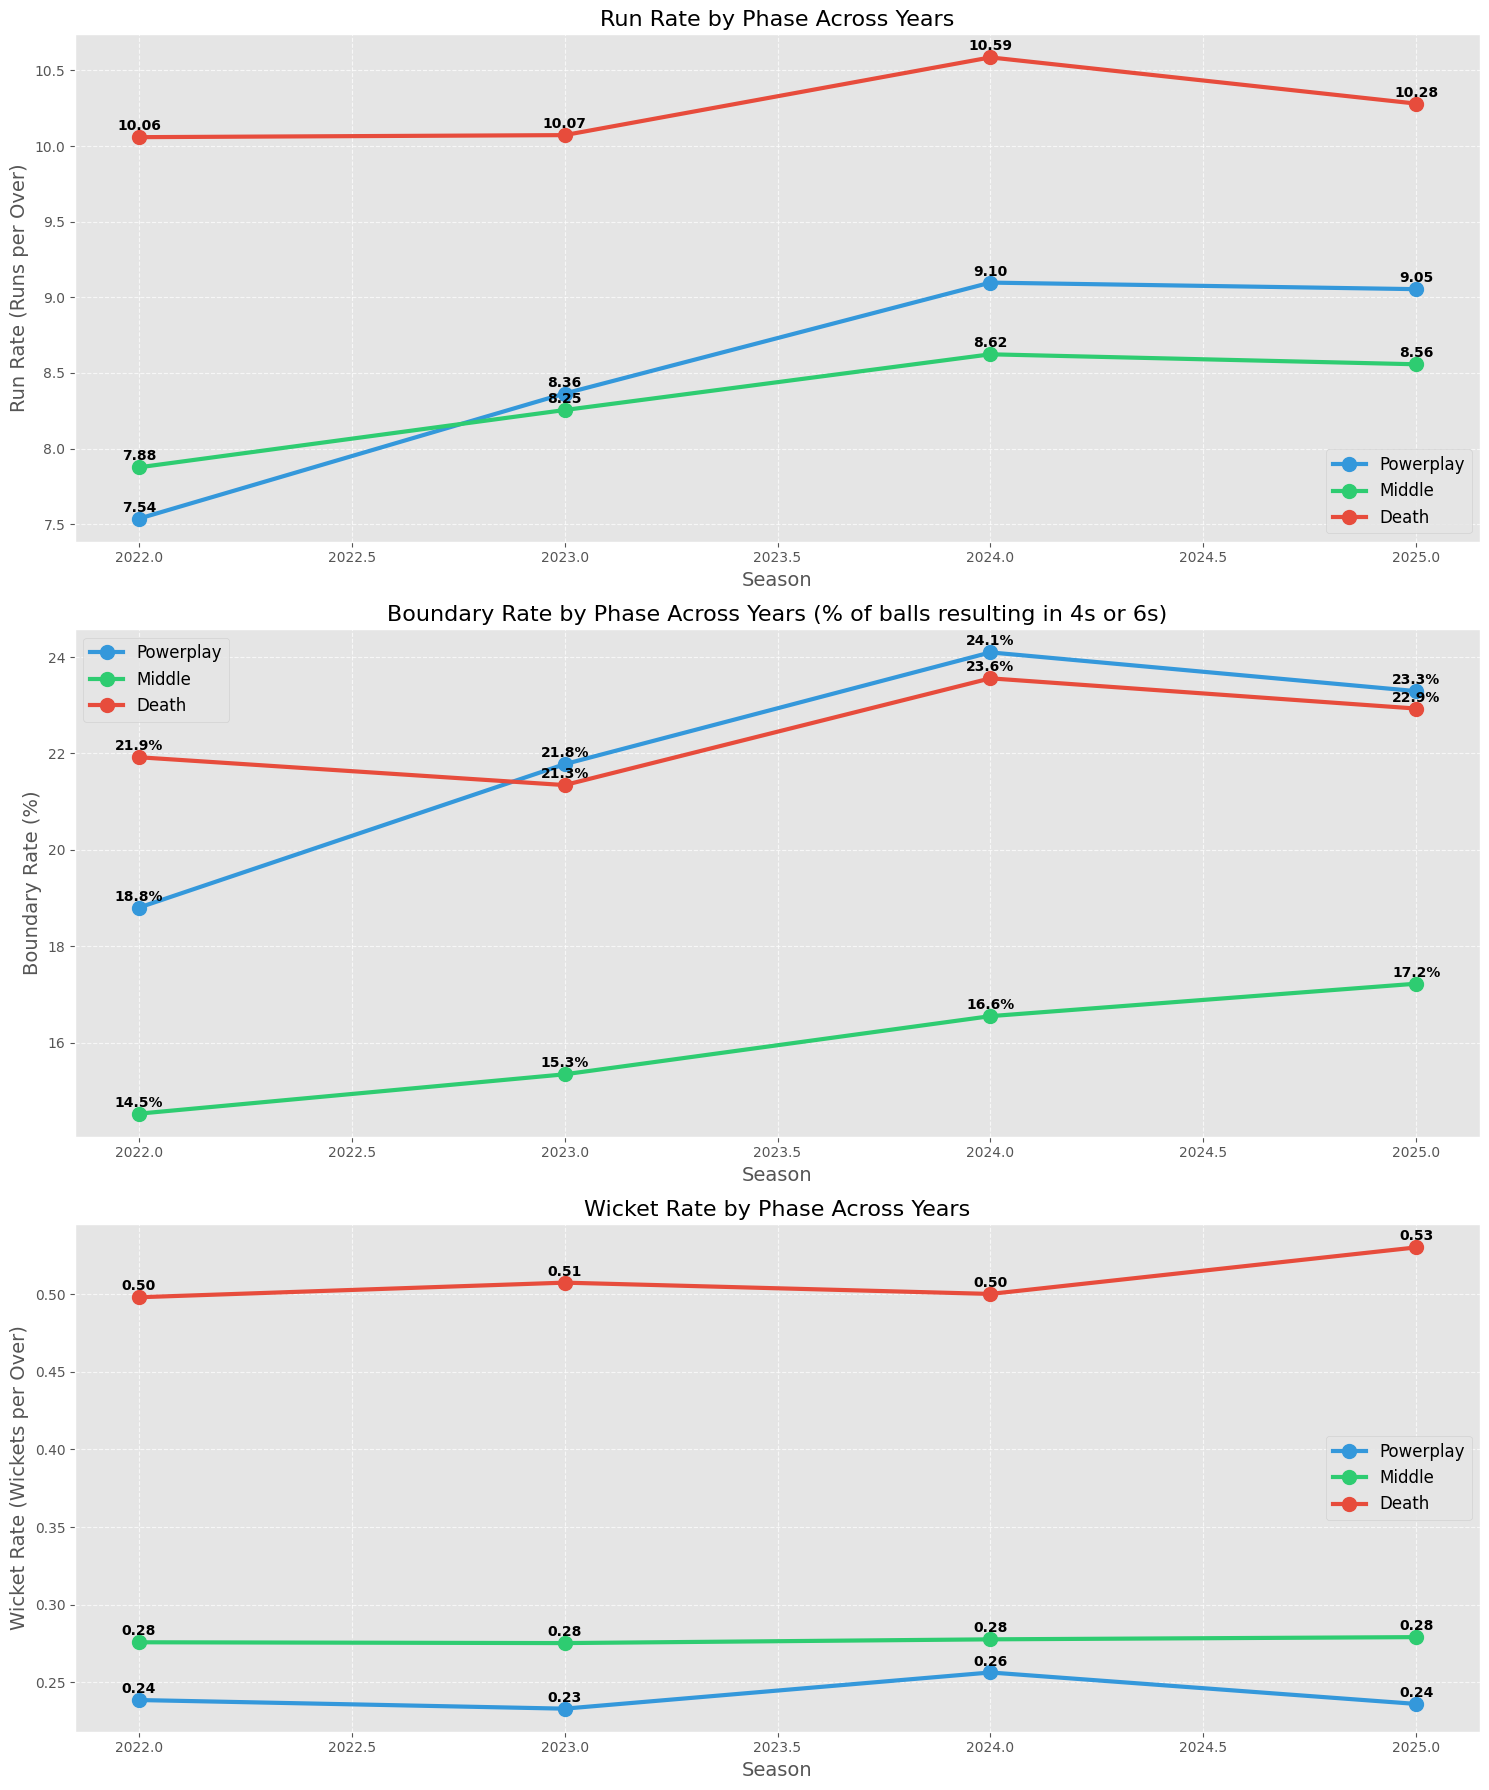

In [16]:
# Calculate phase-wise metrics for each year
phase_metrics = all_ipl.groupby(['season', 'phase']).agg(
    total_runs=('total_runs', 'sum'),
    balls=('total_runs', 'count'),
    fours=('is_four', 'sum'),
    sixes=('is_six', 'sum'),
    wickets=('is_wicket', 'sum')
).reset_index()

# Calculate derived metrics
phase_metrics['run_rate'] = phase_metrics['total_runs'] * 6 / phase_metrics['balls']
phase_metrics['boundary_rate'] = (phase_metrics['fours'] + phase_metrics['sixes']) / phase_metrics['balls']
phase_metrics['wicket_rate'] = phase_metrics['wickets'] * 6 / phase_metrics['balls']

# Create a figure for phase comparison
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# Set up color palettes for each phase
phase_colors = {
    'powerplay': '#3498db',
    'middle': '#2ecc71',
    'death': '#e74c3c'
}

# 1. Run Rate by Phase across Years
for phase in ['powerplay', 'middle', 'death']:
    phase_data = phase_metrics[phase_metrics['phase'] == phase]
    axes[0].plot(phase_data['season'], phase_data['run_rate'], 'o-', 
                linewidth=3, markersize=10, label=phase.capitalize(), color=phase_colors[phase])

axes[0].set_title('Run Rate by Phase Across Years', fontsize=16)
axes[0].set_xlabel('Season', fontsize=14)
axes[0].set_ylabel('Run Rate (Runs per Over)', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend(fontsize=12)

# Add data labels
for phase in ['powerplay', 'middle', 'death']:
    phase_data = phase_metrics[phase_metrics['phase'] == phase]
    for i, row in phase_data.iterrows():
        axes[0].annotate(f"{row['run_rate']:.2f}",
                         xy=(row['season'], row['run_rate']),
                         xytext=(0, 5),
                         textcoords='offset points',
                         ha='center', fontweight='bold')

# 2. Boundary Rate by Phase across Years
for phase in ['powerplay', 'middle', 'death']:
    phase_data = phase_metrics[phase_metrics['phase'] == phase]
    axes[1].plot(phase_data['season'], phase_data['boundary_rate']*100, 'o-', 
                linewidth=3, markersize=10, label=phase.capitalize(), color=phase_colors[phase])

axes[1].set_title('Boundary Rate by Phase Across Years (% of balls resulting in 4s or 6s)', fontsize=16)
axes[1].set_xlabel('Season', fontsize=14)
axes[1].set_ylabel('Boundary Rate (%)', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend(fontsize=12)

# Add data labels
for phase in ['powerplay', 'middle', 'death']:
    phase_data = phase_metrics[phase_metrics['phase'] == phase]
    for i, row in phase_data.iterrows():
        axes[1].annotate(f"{row['boundary_rate']*100:.1f}%",
                         xy=(row['season'], row['boundary_rate']*100),
                         xytext=(0, 5),
                         textcoords='offset points',
                         ha='center', fontweight='bold')

# 3. Wicket Rate by Phase across Years
for phase in ['powerplay', 'middle', 'death']:
    phase_data = phase_metrics[phase_metrics['phase'] == phase]
    axes[2].plot(phase_data['season'], phase_data['wicket_rate'], 'o-', 
                linewidth=3, markersize=10, label=phase.capitalize(), color=phase_colors[phase])

axes[2].set_title('Wicket Rate by Phase Across Years', fontsize=16)
axes[2].set_xlabel('Season', fontsize=14)
axes[2].set_ylabel('Wicket Rate (Wickets per Over)', fontsize=14)
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].legend(fontsize=12)

# Add data labels
for phase in ['powerplay', 'middle', 'death']:
    phase_data = phase_metrics[phase_metrics['phase'] == phase]
    for i, row in phase_data.iterrows():
        axes[2].annotate(f"{row['wicket_rate']:.2f}",
                         xy=(row['season'], row['wicket_rate']),
                         xytext=(0, 5),
                         textcoords='offset points',
                         ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

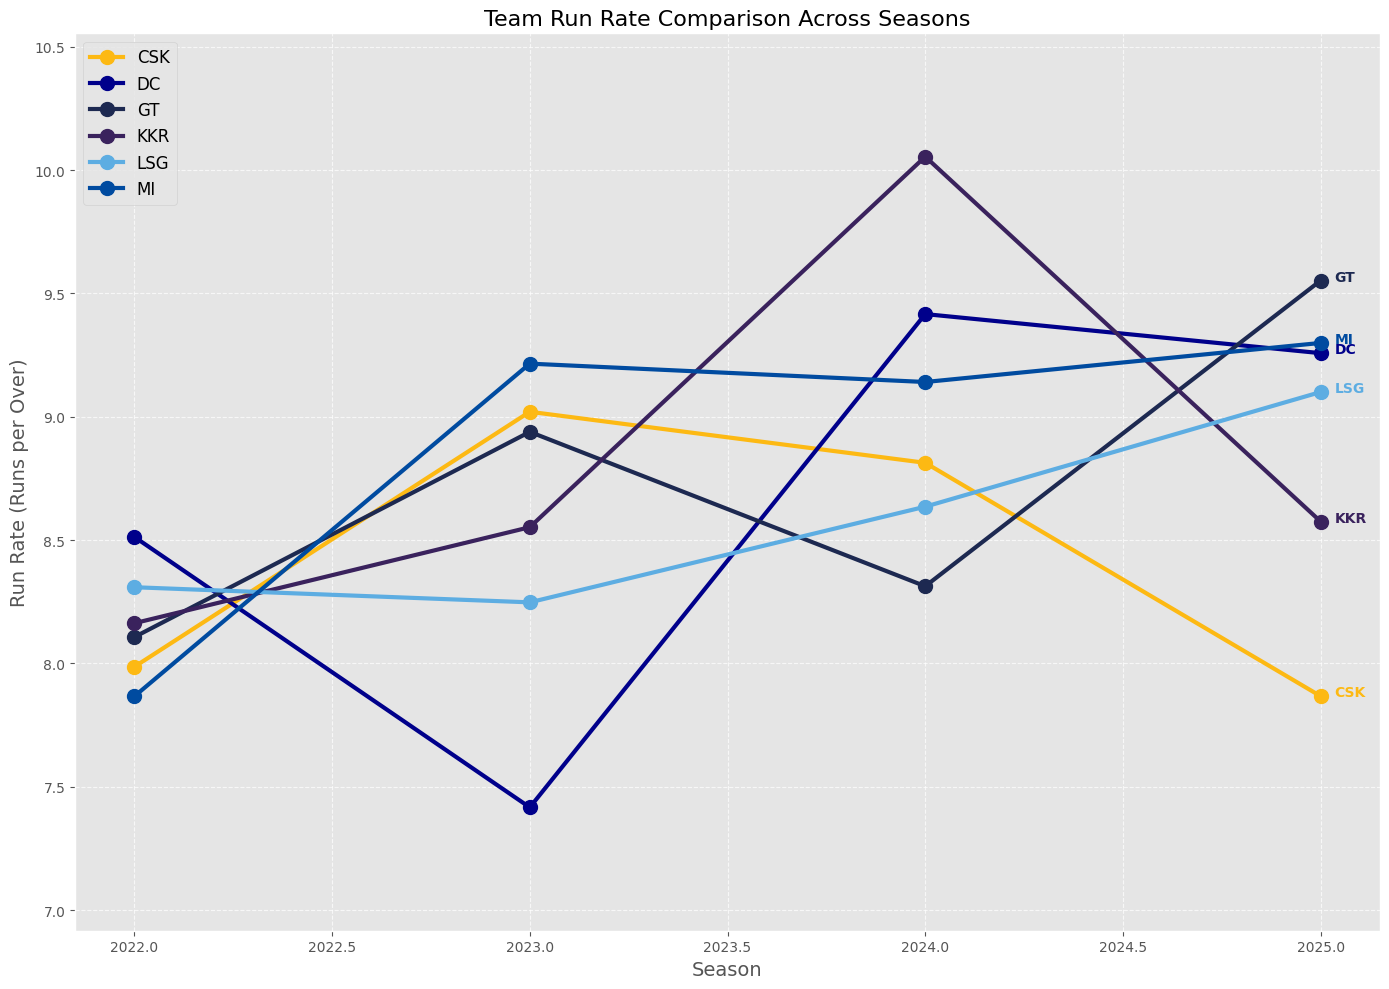

In [17]:
# Calculate team performance by year
team_yearly = all_ipl.groupby(['season', 'batting_team']).agg(
    total_runs=('total_runs', 'sum'),
    balls_faced=('total_runs', 'count'),
    fours=('is_four', 'sum'),
    sixes=('is_six', 'sum')
).reset_index()

team_yearly['run_rate'] = team_yearly['total_runs'] * 6 / team_yearly['balls_faced']

# Get top teams for comparison (teams present in multiple seasons)
team_counts = team_yearly['batting_team'].value_counts()
top_teams = team_counts[team_counts > 1].index.tolist()[:6]  # Top 6 teams with data in multiple seasons

# Filter for selected teams
team_compare = team_yearly[team_yearly['batting_team'].isin(top_teams)]

# Create plot
plt.figure(figsize=(14, 10))

# Set up colors for teams
team_colors = {
    'RCB': '#FF0000',  # Red
    'CSK': '#FDB913',  # Yellow
    'MI': '#004BA0',   # Blue
    'KKR': '#3A225D',  # Purple
    'GT': '#1D2951',   # Navy Blue
    'RR': '#FF69B4',   # Pink
    'SRH': '#FF6600',  # Orange
    'PBKS': '#ED1C24', # Red
    'DC': '#00008B',   # Dark Blue
    'LSG': '#5DADE2'   # Light Blue
}

# Create line chart for run rate by year
for team in top_teams:
    team_data = team_compare[team_compare['batting_team'] == team]
    color = team_colors.get(team, '#333333')  # Default to dark gray if team not in colors dict
    plt.plot(team_data['season'], team_data['run_rate'], 'o-', 
             linewidth=3, markersize=10, label=team, color=color)

# Add labels and formatting
plt.title('Team Run Rate Comparison Across Seasons', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Run Rate (Runs per Over)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12, loc='upper left')

# Set y-axis to start from a reasonable minimum
y_min = max(0, team_compare['run_rate'].min() - 0.5)
plt.ylim(y_min, team_compare['run_rate'].max() + 0.5)

# Add team labels at the end of lines
for team in top_teams:
    team_data = team_compare[team_compare['batting_team'] == team]
    if not team_data.empty:
        last_season = team_data['season'].max()
        last_run_rate = team_data[team_data['season'] == last_season]['run_rate'].values[0]
        plt.annotate(team, 
                     xy=(last_season, last_run_rate),
                     xytext=(10, 0),
                     textcoords='offset points',
                     fontweight='bold',
                     color=team_colors.get(team, '#333333'))

plt.tight_layout()
plt.show()

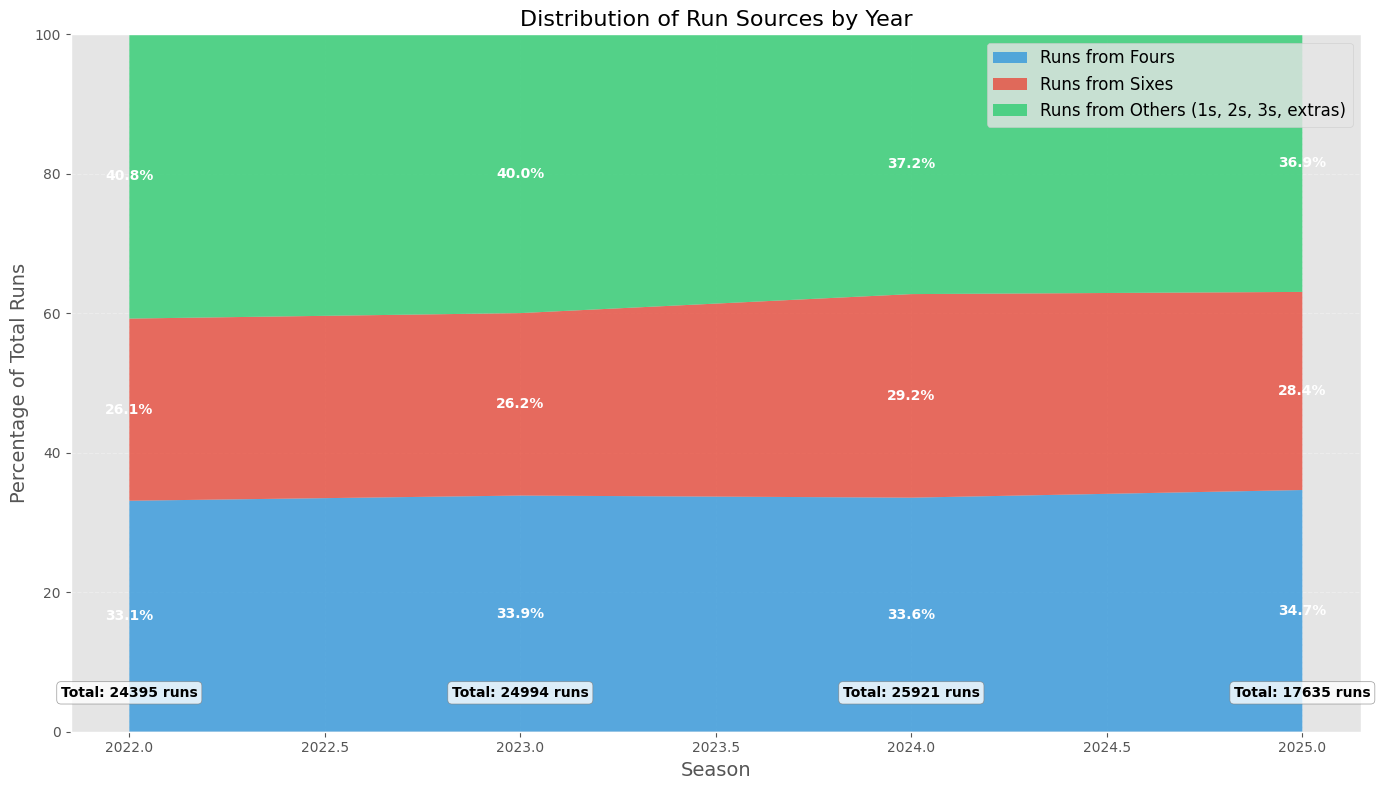

In [18]:
# Calculate percentage of different types of scoring by year
runs_by_type = all_ipl.groupby('season').agg(
    total_runs=('total_runs', 'sum'),
    fours=('is_four', 'sum'),
    sixes=('is_six', 'sum')
).reset_index()

runs_by_type['runs_from_fours'] = runs_by_type['fours'] * 4
runs_by_type['runs_from_sixes'] = runs_by_type['sixes'] * 6
runs_by_type['runs_from_other'] = runs_by_type['total_runs'] - runs_by_type['runs_from_fours'] - runs_by_type['runs_from_sixes']

# Convert to percentages
for col in ['runs_from_fours', 'runs_from_sixes', 'runs_from_other']:
    runs_by_type[f'{col}_pct'] = runs_by_type[col] * 100 / runs_by_type['total_runs']

# Create stacked area chart
plt.figure(figsize=(14, 8))

seasons = runs_by_type['season']
y1 = runs_by_type['runs_from_fours_pct']
y2 = runs_by_type['runs_from_sixes_pct']
y3 = runs_by_type['runs_from_other_pct']

plt.stackplot(seasons, 
              [y1, y2, y3], 
              labels=['Runs from Fours', 'Runs from Sixes', 'Runs from Others (1s, 2s, 3s, extras)'],
              colors=['#3498db', '#e74c3c', '#2ecc71'],
              alpha=0.8)

# Add percentages in the middle of each section
for i, season in enumerate(seasons):
    # For fours
    plt.text(season, y1[i]/2, f"{y1[i]:.1f}%", ha='center', va='center', fontweight='bold', color='white')
    
    # For sixes
    plt.text(season, y1[i] + y2[i]/2, f"{y2[i]:.1f}%", ha='center', va='center', fontweight='bold', color='white')
    
    # For others
    plt.text(season, y1[i] + y2[i] + y3[i]/2, f"{y3[i]:.1f}%", ha='center', va='center', fontweight='bold', color='white')

plt.title('Distribution of Run Sources by Year', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Percentage of Total Runs', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.ylim(0, 100)

# Add overall run totals as annotations
for i, season in enumerate(seasons):
    plt.annotate(f"Total: {runs_by_type['total_runs'][i]} runs",
                 xy=(season, 5),
                 ha='center',
                 fontsize=10,
                 fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='gray', alpha=0.8))

plt.tight_layout()
plt.show()

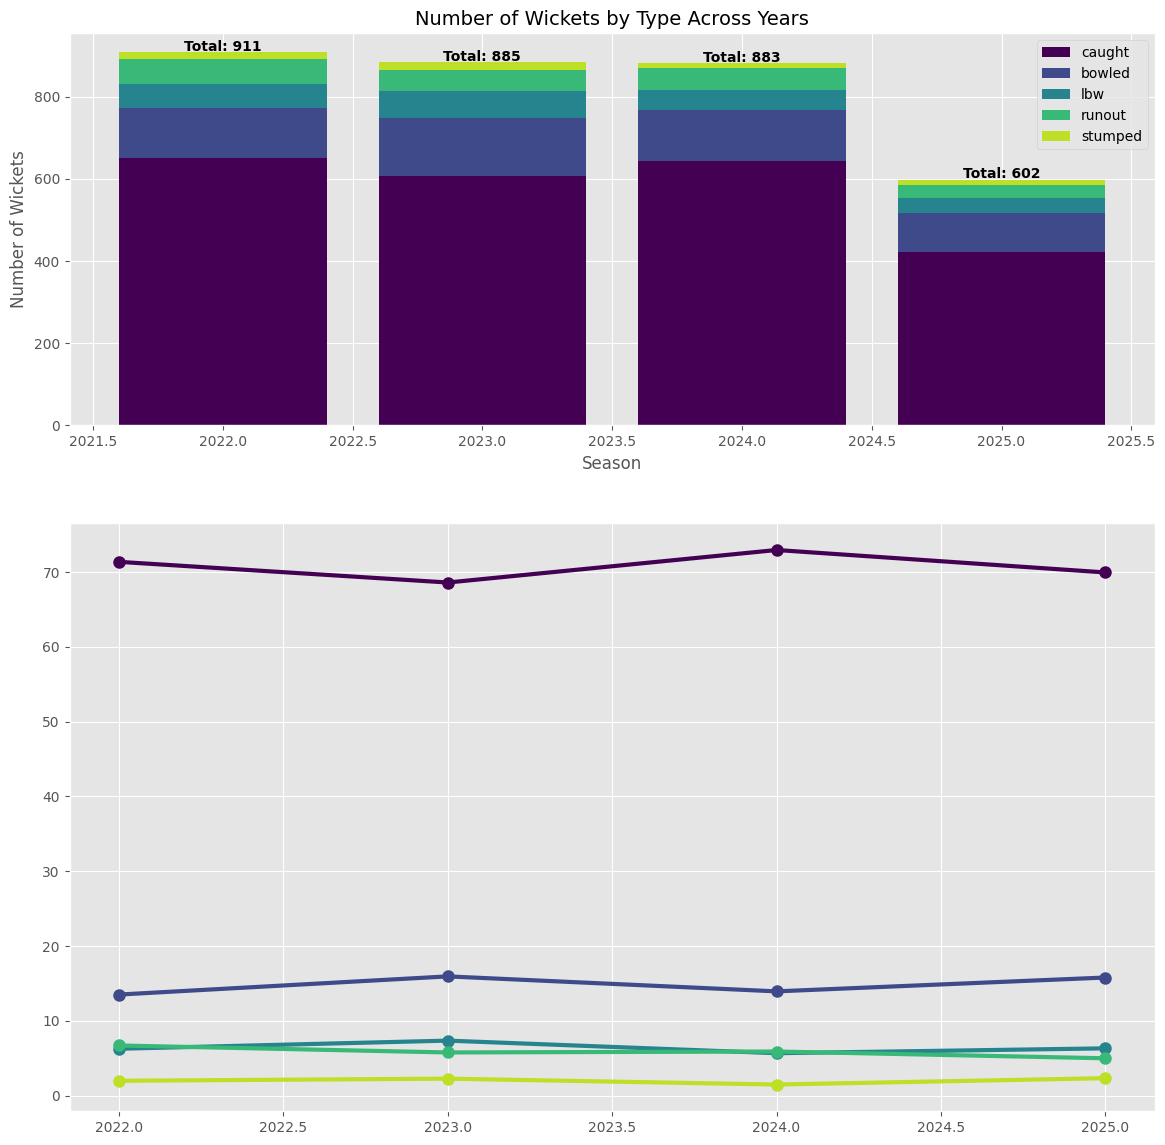

In [19]:
# Calculate wicket type distribution by year
wicket_types = all_ipl[all_ipl['is_wicket']].groupby(['season', 'wicket_type']).size().unstack(fill_value=0)

# Calculate total wickets per season
total_wickets = wicket_types.sum(axis=1).rename('total')
wicket_types = pd.concat([wicket_types, total_wickets], axis=1)

# Get top 5 wicket types
top_wicket_types = all_ipl[all_ipl['is_wicket']]['wicket_type'].value_counts().nlargest(5).index.tolist()

# Calculate percentages
wicket_pct = wicket_types.copy()
for wt in top_wicket_types:
    if wt in wicket_pct.columns:
        wicket_pct[wt] = wicket_pct[wt] * 100 / wicket_pct['total']

# Create plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14), gridspec_kw={'height_ratios': [1, 1.5]})

# 1. Stacked Bar Chart for Absolute Numbers
bottom = np.zeros(len(wicket_types))
colors = plt.cm.viridis(np.linspace(0, 0.9, len(top_wicket_types)))

for i, wt in enumerate(top_wicket_types):
    if wt in wicket_types.columns:
        ax1.bar(wicket_types.index, wicket_types[wt], bottom=bottom, label=wt, color=colors[i])
        bottom += wicket_types[wt].values

ax1.set_title('Number of Wickets by Type Across Years', fontsize=14)
ax1.set_xlabel('Season', fontsize=12)
ax1.set_ylabel('Number of Wickets', fontsize=12)
ax1.legend(fontsize=10)

# Add total wicket labels
for i, season in enumerate(wicket_types.index):
    ax1.annotate(f"Total: {wicket_types.loc[season, 'total']}",
                xy=(season, wicket_types.loc[season, 'total'] + 1),
                ha='center',
                fontweight='bold')

# 2. Line Chart for Percentage Trends
for i, wt in enumerate(top_wicket_types):
    if wt in wicket_pct.columns:
        ax2.plot(wicket_pct.index, wicket_pct[wt], 'o-', 
                linewidth=3, markersize=8, label=wt, color=colors[i])
        
        # Add percentage labels
        for j, season in enumerate(wicket_pct.index):
            ax2.annotate